# Collect identifiability and sensitibity results and make SI figures

This notebooks creates fugures for both CD8 and CD4 data. The figure combines results from different analyses:

* Sensitivity matrix plots
* Heatmap of practical identifiability
* Model identifiability
* Q coefficients within a model
* Repeat for CD8 and CD4 lineage

To get these results, first run the notebooks

* `IdentifiabilityAnalysis.ipynb`
* `ModelIdentifiability.ipynb`
* `SensitivityAnalysis.ipynb`

<div class="alert alert-block alert-info"> <b>NOTE</b> 
    Note that these three notebooks also depend on upstream analyses.
</div>


In [ ]:
import pickle
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from scdynsys import utilities as utils
import scipy.stats as sts

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

## Collect data

and previously defined names for the sub-populations

In [390]:
with open("../results/data_figure_sens.pkl", 'rb') as f:
    sens_data_dict = pickle.load(f)

focal_models = sens_data_dict["focal_models"]
num_clusters = sens_data_dict["num_clusters"]
celltype_names = sens_data_dict["celltype_names"]
trans_sens_results_Q = sens_data_dict["trans_sens_results_Q"]
ts = sens_data_dict["ts"]
time_ticks = sens_data_dict["time_ticks"]
t0 = sens_data_dict["t0"]

## import "fancy" names for SA clusters

fancy_names_file = f"../results/fancy_names_SA_CD8.pkl"
with open(fancy_names_file, 'rb') as f:
    fancy_names_CD8 = pickle.load(f)

fancy_names_file = f"../results/fancy_names_SA_CD4.pkl"
with open(fancy_names_file, 'rb') as f:
    fancy_names_CD4 = pickle.load(f)

fancy_names = {
    "CD8" : fancy_names_CD8,
    "CD4" : fancy_names_CD4,
}

## import data from identifiability analysis

with open("../results/data_figure_ident.pkl", 'rb') as f:
    ident_data_dict = pickle.load(f)

corr_mat_dict = ident_data_dict["corr_mat_dict"]
pval_mat_dict = ident_data_dict["pval_mat_dict"]


## import model identifiability data

with open("../results/data_figure_model_ident.pkl", 'rb') as f:
    model_ident_data_dict = pickle.load(f)

## Define functions for plotting the different components of the figure

This way, we can neatly make the CD4 and CD8 figures without repeating too much code.

### Plot the sensitivity matrix

In the notebook `SensitivityAnalysis.ipynb` we already developed a prototype for this plot.
Having matplotlib figures with many different panels (e.g. $11^2 = 121$ for the CD4 lineage)
is highly time-consuming and does not lead to nice results easily.
Therefore we take an approach where we plot all curves in the same panel, and apply affine
transformations to put them in a grid.

In [ ]:
# sqrt-scale for sensitivity plots
def sqrt_transform(xs):
    return np.sign(xs) * np.sqrt(np.abs(xs))


def plot_Q_sens_matrix(ax, lineage, var, transform, ymin, ymax, val_ticks, time_ticks):
    model = focal_models[lineage]
    num_clus = num_clusters[lineage]
    ct_names = celltype_names[lineage]
    trans_sens_result_Q = trans_sens_results_Q[lineage]

    def affine_transform(xs, ys, i, j, n, xmin, xmax, ymin, ymax):
        txs = (xs - xmin) / (n*(xmax-xmin)) + j/n
        tys = (ys - ymin) / (n*(ymax-ymin)) + i/n
        return txs, tys

    fymin = transform(ymin)
    fymax = transform(ymax)
    
    for i in range(num_clus):
        for j in range(num_clus):
            if i == j:
                continue
            if var == "pi":
                for k in range(num_clus):
                    xs = trans_sens_result_Q["ddQ_logitpi"][k,i,j,:] ## should be j -> i for cluster k
                    fxs = transform(xs)
                    tts, txs = affine_transform(ts, fxs, i, j, num_clus, t0-2, np.max(ts)+1, fymin, fymax)
                    if i == k:
                        ax.plot(tts, txs, color='k', linewidth=1, zorder=2) 
                    elif k == j:
                        ax.plot(tts, txs, color='r', linewidth=1, zorder=1) 
                    else:
                        ax.plot(tts, txs, color='0.7', linewidth=0.5, zorder=1) 
            elif var == "y":
                xs = trans_sens_result_Q["ddQ_logy"][i,j,:] ## should be j -> i
                fxs = transform(xs)
                tts, txs = affine_transform(ts, fxs, i, j, num_clus, t0-2, np.max(ts)+1, fymin, fymax)
                ax.plot(tts, txs, color='b', linewidth=1, zorder=2)
            else:
                raise Exception("var must be 'pi' or 'y'")

    # plot a grid
    for i in range(1,num_clus):
        ax.axvline(i/num_clus, color='k', linewidth=0.5)
    for j in range(1,num_clus):
        ax.axhline(j/num_clus, color='k', linewidth=0.5)
    
    ax.set(xlim=(0,1), ylim=(0,1))

    # add x and y ticks
    
    xticks, xticklabs = [], []
    yticks, yticklabs = [], []

    fval_ticks = transform(val_ticks)
    
    for j in range(num_clus):
        sub_xticks, sub_yticks = affine_transform(time_ticks, fval_ticks, j, j, num_clus, t0-2, np.max(ts)+1, fymin, fymax)
        xticks.append(sub_xticks)
        xticklabs.append(time_ticks)
        yticks.append(sub_yticks)
        yticklabs.append(val_ticks)

    ax.set_xticks(np.concatenate(xticks))
    ax.set_xticklabels(np.concatenate(xticklabs), fontsize='small')
    ax.set_yticks(np.concatenate(yticks))
    ax.set_yticklabels(np.concatenate(yticklabs), fontsize='small')

    # add cell types
    for i in range(num_clus):
        ct = ct_names[i]
        fct = fancy_names[lineage][ct]
        source_col = 'red' if var == "pi" else "k"
        ax.text(-0.05, (i + 0.5) / num_clus, fct, va='top', ha='right', fontsize='small', rotation=45)
        ax.text((i + 0.5) / num_clus, -0.05, fct, va='top', ha='right', color=source_col, fontsize='small', rotation=45)

### The identifiability matrix

This plot is much simpler as this is just a heatmap showing correlation coefficients and stars (`*`) indicating statistical significance.

In [392]:
def plot_Q_ident_matrix(ax, lineage):
    corr_mat = corr_mat_dict[lineage]
    pval_mat = pval_mat_dict[lineage]

    num_clus = num_clusters[lineage]
    ct_names = celltype_names[lineage]

    mask = np.eye(num_clus, dtype=int)
    corr_mat_masked = np.ma.array(corr_mat, mask=mask)
    
    h, w = corr_mat_masked.shape
    C = ax.pcolor(np.arange(h+1), np.arange(w+1), corr_mat_masked, cmap='RdBu_r', vmin=-1, vmax=1)
    fig = ax.get_figure()
    cx = fig.colorbar(C, shrink=0.5)
    
    cx.set_label("Spearman correlation $Q_{ij}$")
    
    for i in range(num_clus):
        for j in range(num_clus):
            if i == j:
                continue
            st = utils.sign_stars(pval_mat[i,j])
            ax.text(j+0.5, i+0.5, st, va='center', ha='center')
    
    ticks = np.linspace(0, num_clus-1, num_clus) + 0.5
    ax.set(xticks=ticks, yticks=ticks)
    fct_names = [fancy_names[lineage][ct] for ct in ct_names]
    ax.set_xticklabels(fct_names, rotation=45, ha='right', fontsize='small')
    ax.set_yticklabels(fct_names, rotation=45, va='top', fontsize='small')
    ax.set_aspect('equal', adjustable='box', anchor='NW')

### Model identifiability

This is just a simple heatmap.

In [ ]:
def plot_model_ident_matrix(ax, weight_matrix):
    C = ax.pcolor(weight_matrix, cmap='hot', vmin=0, vmax=1)
    ax.set_aspect('equal', anchor='NE')
    fig = ax.get_figure()
    cs = fig.colorbar(C, shrink=0.7)
    cs.set_label("model weight")

    ax.set_xlabel("fitted model")
    ax.set_ylabel("data generation model")

    ticks = np.linspace(0,3,4) + 0.5
    labs = ["I", "II", "III", "IV"]
    ax.set(xticks=ticks, yticks=ticks)
    ax.set(xticklabels=labs, yticklabels=labs)

### Re-fitting

This panel shows how well we can estimate $Q_{ij}$ values if we (pretend to) know the ground truth. This is a simple scatter plot.

In [394]:
def plot_refit_Q_est(ax, xylim, Q_gt_offdiag, Q_est_offdiag_low, Q_est_offdiag_med, Q_est_offdiag_high):
    ax.scatter(Q_gt_offdiag, Q_est_offdiag_med, s=1, color='k')
    for i, x in enumerate(Q_gt_offdiag):
        l, u = Q_est_offdiag_low[i], Q_est_offdiag_high[i]
        ax.plot([x, x], [l, u], color='k', linewidth=0.5)

    ax.set(xlim=xylim, ylim=xylim)

## Make the CD8 figure

/tmp/ipykernel_1085238/3819613793.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cx = fig.colorbar(C, shrink=0.5)


Text(-0.2, 1.05, 'E')

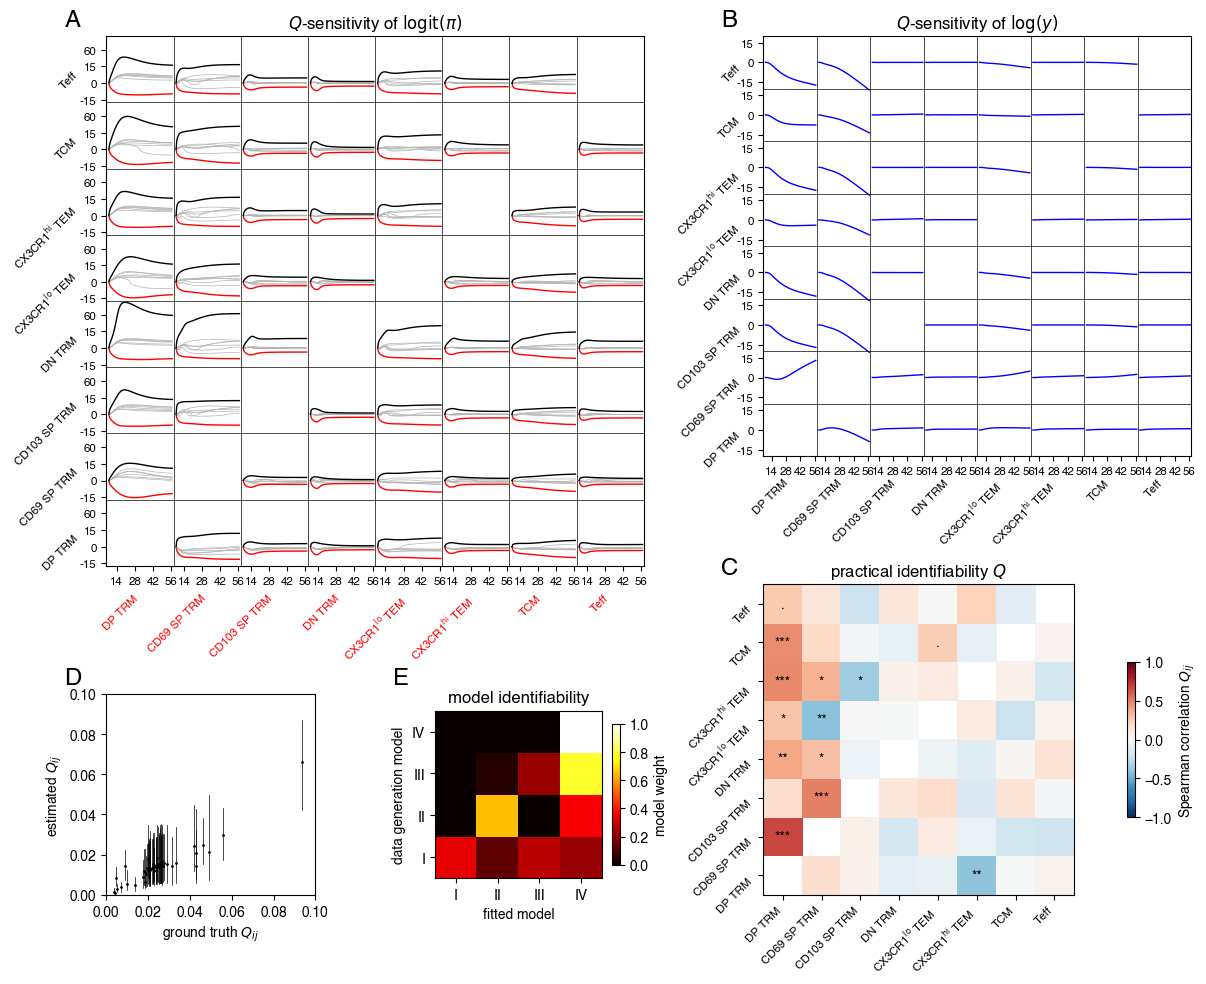

In [402]:
fig = plt.figure(figsize=(14, 14))

gs = GridSpec(10, 10, wspace=0.1, hspace=0.2)

labx, laby = -0.2, 1.05

ax = fig.add_subplot(gs[:5,:5])
val_ticks = np.array([-15, 0, 15, 60])
plot_Q_sens_matrix(ax, "CD8", "pi", sqrt_transform, -20, 120, val_ticks, time_ticks)
ax.set_title("$Q$-sensitivity of $\\text{logit}(\\pi)$")
Ax = fig.add_subplot(gs[:2,:2])
Ax.axis('off')
Ax.text(labx, laby, 'A', fontsize='xx-large', transform=Ax.transAxes)

bx = fig.add_subplot(gs[:4,6:10])
val_ticks = np.array([-15, 0, 15])
plot_Q_sens_matrix(bx, "CD8", "y", lambda x: x, -20, 20, val_ticks, time_ticks)
bx.set_title("$Q$-sensitivity of $\\log(y)$")
Bx = fig.add_subplot(gs[:2,6:8])
Bx.axis('off')
Bx.text(labx, laby, 'B', fontsize='xx-large', transform=Bx.transAxes)


# Q-identifiability plot

cx = fig.add_subplot(gs[5:8, 6:10])
plot_Q_ident_matrix(cx, "CD8")
cx.set_title("practical identifiability $Q$")
Cx = fig.add_subplot(gs[5:7, 6:8])
Cx.axis('off')
Cx.text(labx, laby, 'C', fontsize='xx-large', transform=Cx.transAxes)

# Q-ident re-fit

dx = fig.add_subplot(gs[6:8, :2])

refit_data = ident_data_dict["refit_Q_estimates"]["CD8"]
plot_refit_Q_est(dx, (0, 0.1), **refit_data)
    
dx.set_xlabel("ground truth $Q_{ij}$")
dx.set_ylabel("estimated $Q_{ij}$")

Dx = fig.add_subplot(gs[6:8, :2])
Dx.axis('off')
Dx.text(labx, laby, 'D', fontsize='xx-large', transform=Dx.transAxes)


# model-identifiability plot

ex = fig.add_subplot(gs[6:8, 3:5])

weight_matrix = model_ident_data_dict["weight_matrix_dict"]["CD8"]
plot_model_ident_matrix(ex, weight_matrix)
ex.set_title("model identifiability")

Ex = fig.add_subplot(gs[6:8, 3:5])
Ex.axis('off')
Ex.text(labx, laby, 'E', fontsize='xx-large', transform=Ex.transAxes)


In [ ]:
#fig.savefig("../results/FigureIdentifiabilityCD8.pdf", bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


## Make the CD4 figure

/tmp/ipykernel_1085238/3819613793.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cx = fig.colorbar(C, shrink=0.5)


Text(-0.2, 1.05, 'E')

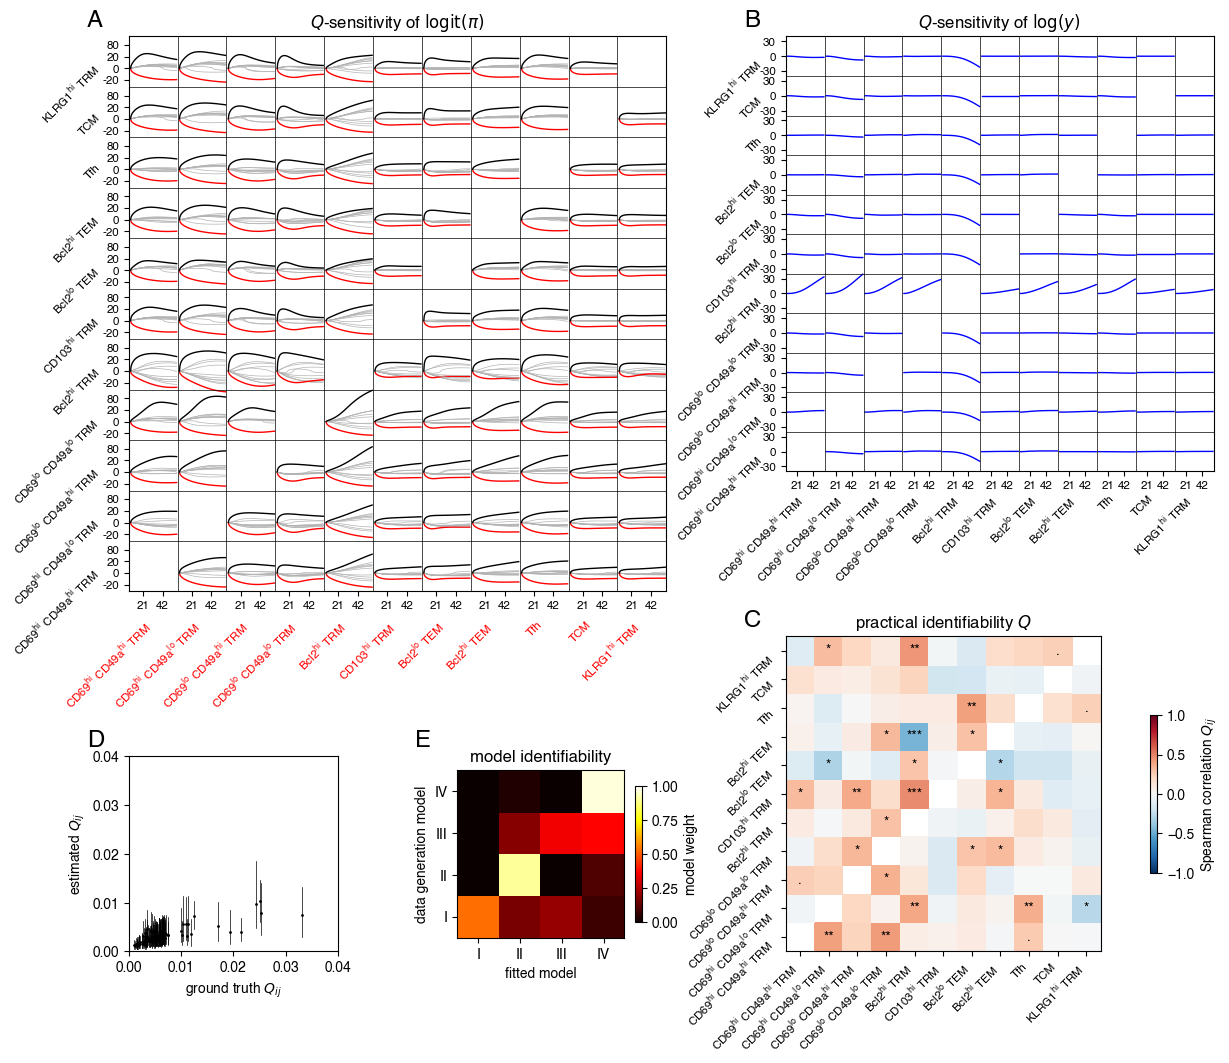

In [405]:
fig = plt.figure(figsize=(14, 15))

gs = GridSpec(10, 10, wspace=0.1, hspace=0.6)

labx, laby = -0.2, 1.05

# we don't have enough space for 4 ticks :-(
time_ticks_CD4 = np.array([21, 42])

ax = fig.add_subplot(gs[:5,:5])
val_ticks = np.array([-20, 0, 20, 80])
plot_Q_sens_matrix(ax, "CD4", "pi", sqrt_transform, -50, 150, val_ticks, time_ticks_CD4)
ax.set_title("$Q$-sensitivity of $\\text{logit}(\\pi)$")
Ax = fig.add_subplot(gs[:2,:2])
Ax.axis('off')
Ax.text(labx, laby, 'A', fontsize='xx-large', transform=Ax.transAxes)

bx = fig.add_subplot(gs[:4,6:10])
val_ticks = np.array([-30, 0, 30])
plot_Q_sens_matrix(bx, "CD4", "y", lambda x: x, -40, 40, val_ticks, time_ticks_CD4)
bx.set_title("$Q$-sensitivity of $\\log(y)$")
Bx = fig.add_subplot(gs[:2,6:8])
Bx.axis('off')
Bx.text(labx, laby, 'B', fontsize='xx-large', transform=Bx.transAxes)


# Q-identifiability plot

cx = fig.add_subplot(gs[5:8, 6:10])
plot_Q_ident_matrix(cx, "CD4")
cx.set_title("practical identifiability $Q$")
Cx = fig.add_subplot(gs[5:7, 6:8])
Cx.axis('off')
Cx.text(labx, laby, 'C', fontsize='xx-large', transform=Cx.transAxes)

# Q-ident re-fit

dx = fig.add_subplot(gs[6:8, :2])

refit_data = ident_data_dict["refit_Q_estimates"]["CD4"]
plot_refit_Q_est(dx, (0, 0.04), **refit_data)


dx.set_xlabel("ground truth $Q_{ij}$")
dx.set_ylabel("estimated $Q_{ij}$")

Dx = fig.add_subplot(gs[6:8, :2])
Dx.axis('off')
Dx.text(labx, laby, 'D', fontsize='xx-large', transform=Dx.transAxes)


# model-identifiability plot

ex = fig.add_subplot(gs[6:8, 3:5])

weight_matrix = model_ident_data_dict["weight_matrix_dict"]["CD4"]
plot_model_ident_matrix(ex, weight_matrix)
ex.set_title("model identifiability")

Ex = fig.add_subplot(gs[6:8, 3:5])
Ex.axis('off')
Ex.text(labx, laby, 'E', fontsize='xx-large', transform=Ex.transAxes)


In [ ]:
#fig.savefig("../results/FigureIdentifiabilityCD4.pdf", bbox_inches='tight')

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped
